In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import seaborn as sns

np.set_printoptions(threshold=np.inf)

Using TensorFlow backend.


In [2]:
raw_data = pd.read_csv('data/train.csv')

C:\Users\Ethan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
raw_data.columns

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'Yards', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')

In [5]:
plays = np.unique(raw_data['PlayId'])
plays_trn, plays_tst = train_test_split(plays, train_size=0.75)
data_trn = raw_data[raw_data['PlayId'].isin(plays_trn)]
data_tst = raw_data[raw_data['PlayId'].isin(plays_tst)]

In [15]:
BUFFER = 60
offense_player_count = np.zeros((BUFFER*2+1,BUFFER*2+1))
defense_player_count = np.zeros((BUFFER*2+1,BUFFER*2+1))
total_player_count = np.zeros((BUFFER*2+1,BUFFER*2+1))
offense_mean_yards = np.zeros((BUFFER*2+1,BUFFER*2+1))
defense_mean_yards = np.zeros((BUFFER*2+1,BUFFER*2+1))
total_mean_yards = np.zeros((BUFFER*2+1,BUFFER*2+1))
for _,play in data_trn.groupby(['PlayId']):
    offense_team = play.loc[play['NflId'] == play['NflIdRusher'],'Team'].iloc[0]
    direction = play['PlayDirection'].iloc[0]
    yards = play['Yards'].iloc[0]
    ox = play.loc[play['NflId'] == play['NflIdRusher'],'X'].iloc[0]
    oy = play.loc[play['NflId'] == play['NflIdRusher'],'Y'].iloc[0]
    for _,player in play.iterrows():
        x = int(round(player['X']-ox+BUFFER)) if direction == 'right' else int(round(ox-player['X']+BUFFER))
        y = int(round(player['Y']-oy+BUFFER))
        if player['Team'] == offense_team:
            offense_player_count[y,x] += 1
            offense_mean_yards[y,x] = offense_mean_yards[y,x] + (yards - offense_mean_yards[y,x]) / offense_player_count[y,x]
        else:
            defense_player_count[y,x] += 1
            defense_mean_yards[y,x] = defense_mean_yards[y,x] + (yards - defense_mean_yards[y,x]) / defense_player_count[y,x]

In [20]:
total_player_count = offense_player_count + defense_player_count
total_mean_yards = (offense_mean_yards * offense_player_count + defense_mean_yards * defense_player_count) / total_player_count
total_mean_yards[total_player_count == 0] = 0

C:\Users\Ethan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [30]:
se = []
pct = []
for _,play in data_tst.groupby(['PlayId']):
    offense_team = play.loc[play['NflId'] == play['NflIdRusher'],'Team'].iloc[0]
    direction = play['PlayDirection'].iloc[0]
    yards = play['Yards'].iloc[0]
    ox = play.loc[play['NflId'] == play['NflIdRusher'],'X'].iloc[0]
    oy = play.loc[play['NflId'] == play['NflIdRusher'],'Y'].iloc[0]
    predictions = []
    weights = []
    for _,player in play.iterrows():
        x = int(round(player['X']-ox+BUFFER)) if direction == 'right' else int(round(ox-player['X']+BUFFER))
        y = int(round(player['Y']-oy+BUFFER))
        if player['Team'] == offense_team:
            predictions.append(offense_mean_yards[y,x])
            weights.append(offense_player_count[y,x])
        else:
            predictions.append(defense_mean_yards[y,x])
            weights.append(defense_player_count[y,x])
    prediction = np.average(predictions, weights=weights)
    se.append((prediction-yards)*(prediction-yards))
    if yards != 0:
        pct.append(1 - np.abs(prediction-yards)/yards)
print('mse: ' + str(np.mean(se)))
print('pct: ' + str(np.mean(pct)))

mse: 40.76313866594427
pct: 0.6266799344374296


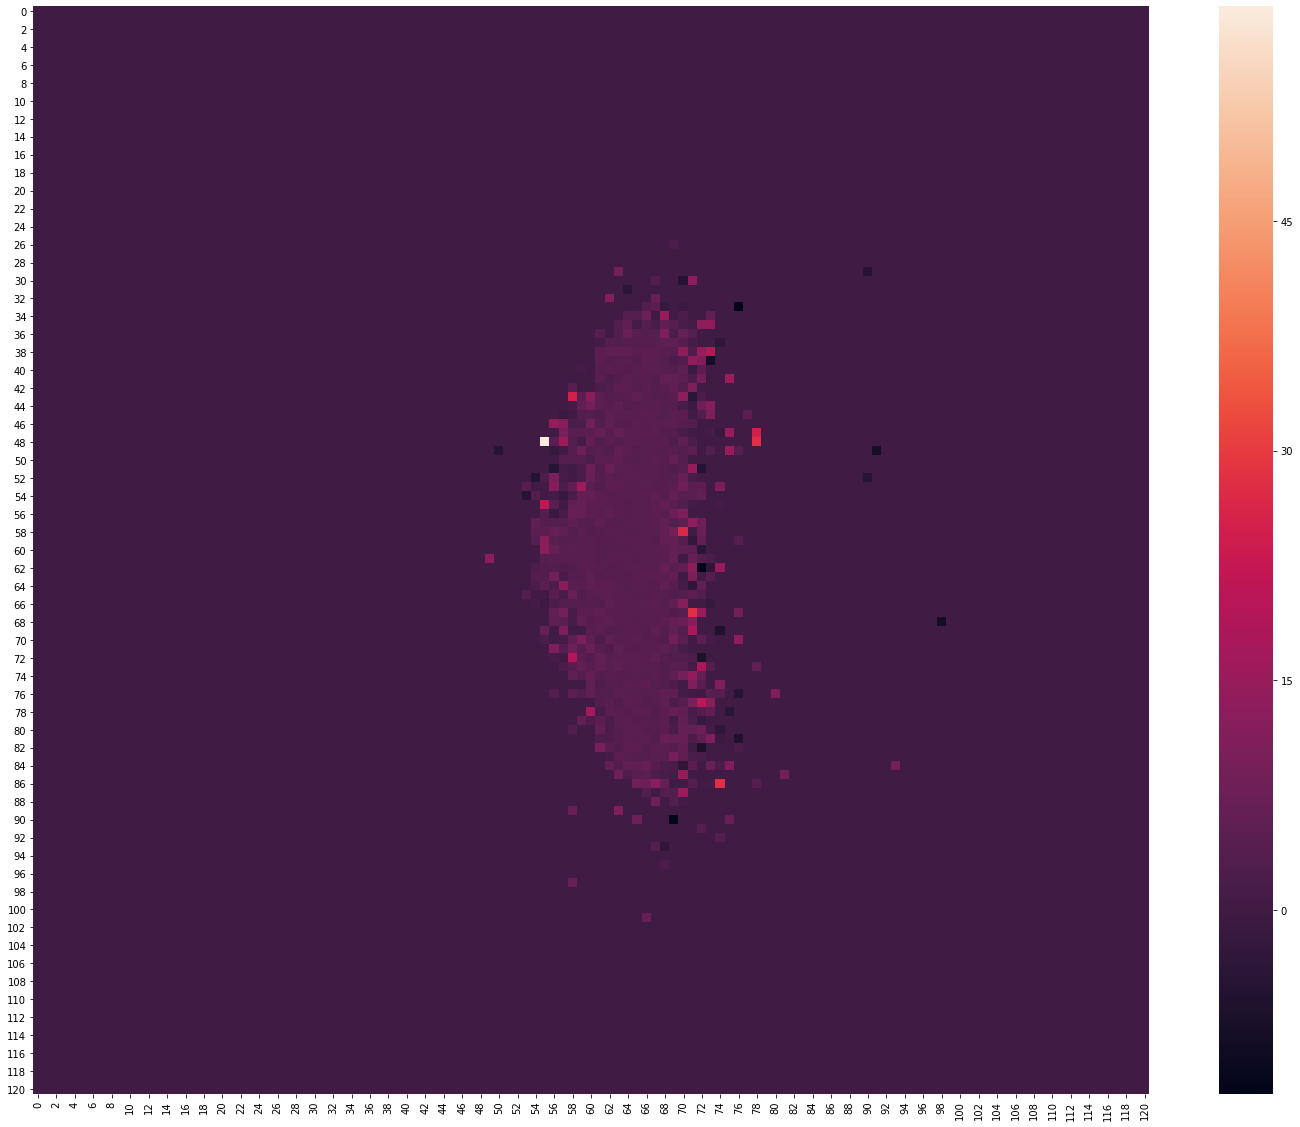

In [17]:
off_fig = plt.figure(figsize=(25,20))
ax = sns.heatmap(offense_mean_yards)

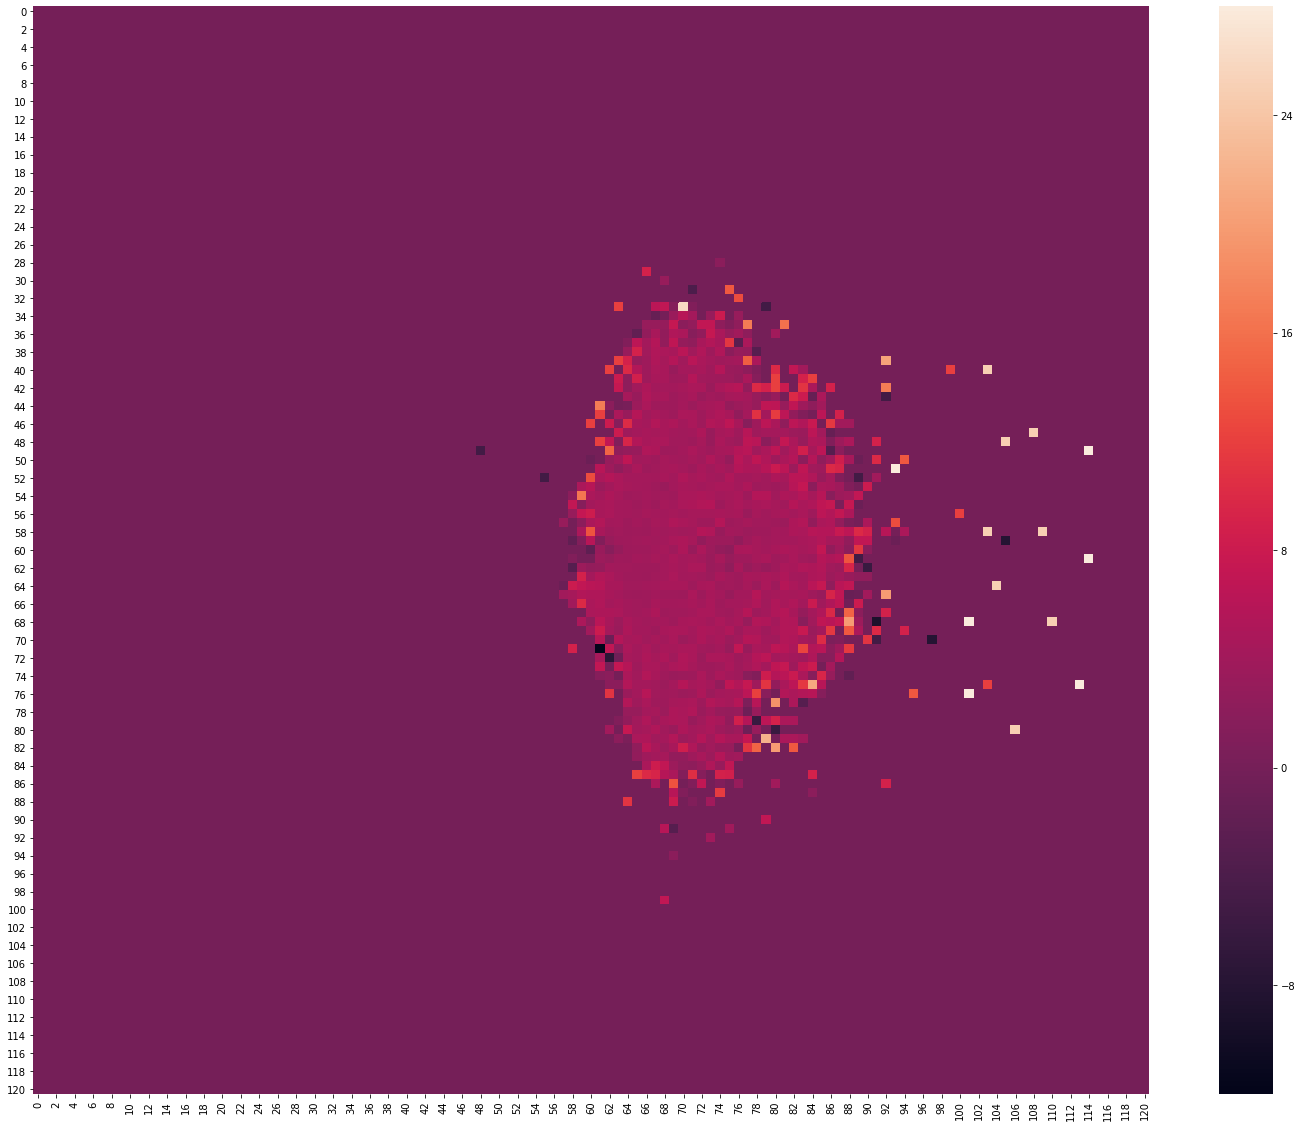

In [18]:
def_fig = plt.figure(figsize=(25,20))
ax = sns.heatmap(defense_mean_yards)

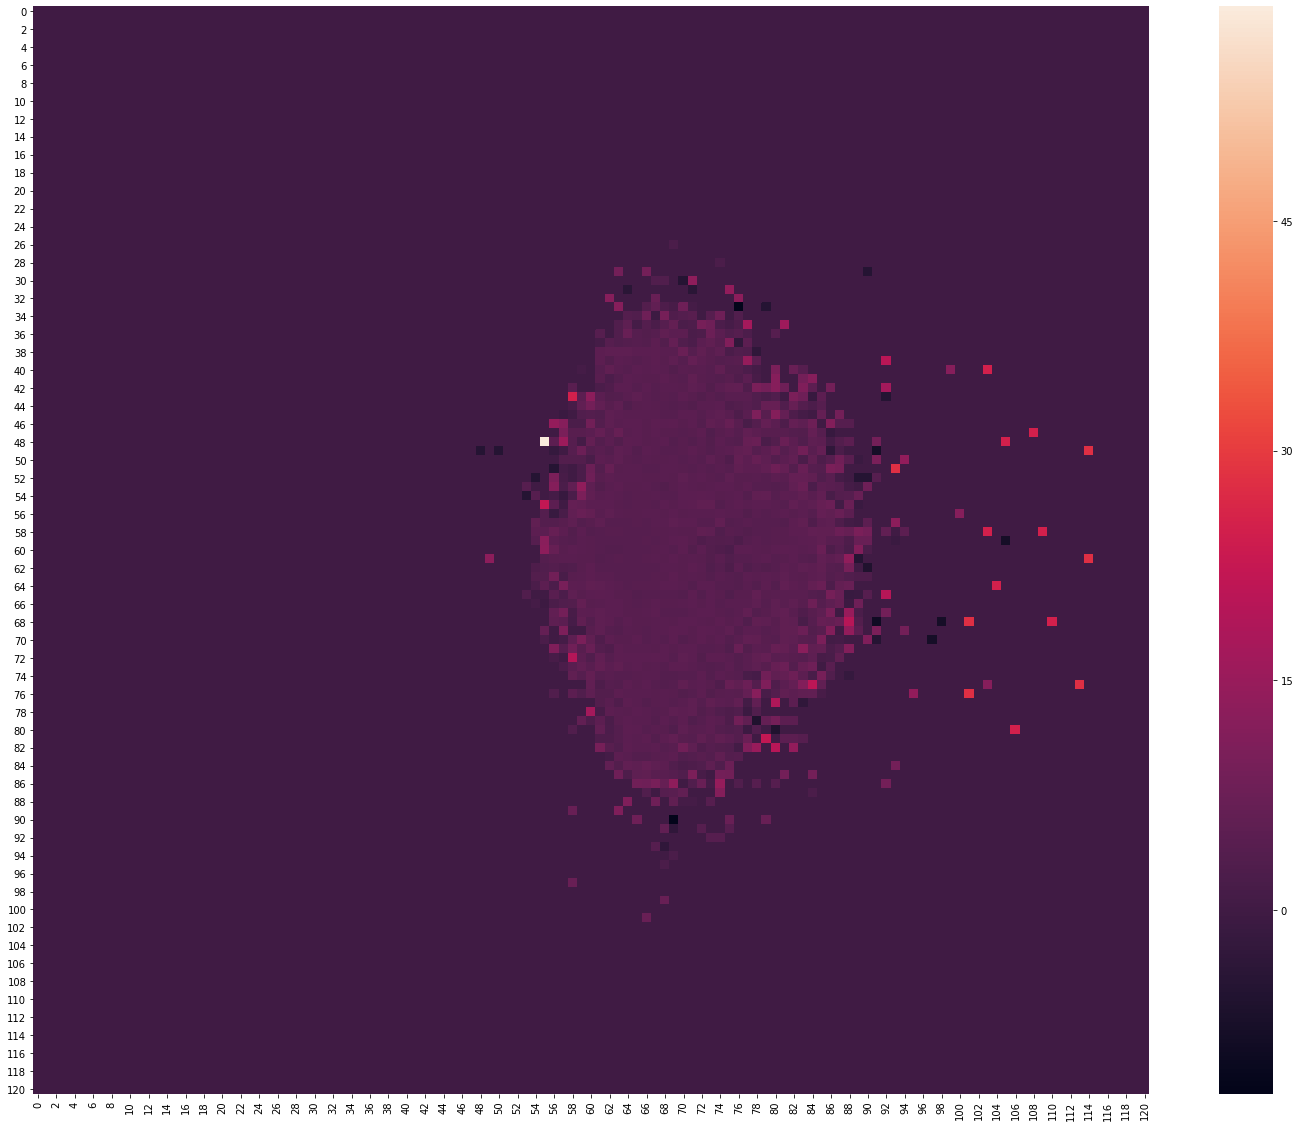

In [23]:
tot_fig = plt.figure(figsize=(25,20))
ax = sns.heatmap(total_mean_yards)